<a href="https://colab.research.google.com/github/rakesh-choudhury/Dataset/blob/master/Budget_Attribution_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Attribution Modeling Increases Efficiency of Bidding in Display Advertising
Eustache Diemert&ast;, Julien Meynet&ast; (Criteo Research), Damien Lefortier (Facebook), Pierre Galland (Criteo)
&ast;authors contributed equally.

This work was published in:
[2017 AdKDD & TargetAd Workshop, in conjunction with
The 23rd ACM SIGKDD Conference on Knowledge Discovery and Data Mining (KDD 2017)](https://adkdd17.wixsite.com/adkddtargetad2017)

  * This code includes all needed material to reproduce results reported in the paper. This dataset can also be used for further research like: testing alternative attribution models, offline metrics, etc..
  * For details about the content of the Dataset, refer to the README file


# Dataset Description
###Timestamp: 
timestamp of the impression (starting from 0 for the first impression). The dataset is sorted according to timestamp.
uid a unique user identifier
###Campaign:
a unique identifier for the campaign
### Conversion:
1 if there was a conversion in the 30 days after the impression (independently of whether this impression was last click or not)
###Conversion_Timestamp:
the timestamp of the conversion or -1 if no conversion was observed
###Conversion_id:
a unique identifier for each conversion (so that timelines can be reconstructed if needed). -1 if there was no conversion
###Attribution 1: 
if the conversion was attributed to Criteo, 0 otherwise
###Click 1:
if the impression was clicked, 0 otherwise
###Click_pos: 
the position of the click before a conversion (0 for first-click)
###Click_nb:
number of clicks. More than 1 if there was several clicks before a conversion
###Cost:
the price paid by Criteo for this display (disclaimer: not the real price, only a transformed version of it)
###CPO(Cost per order):
the cost-per-order in case of attributed conversion (disclaimer: not the real price, only a transformed version of it)
###Time_Since_Last_Click: 
the time since the last click (in s) for the given impression
###Cat[1-9]: 
contextual features associated to the display. Can be used to learn the click/conversion models. We do not disclose the meaning of these features but it is not relevant for this study. Each column is a categorical variable. In the experiments, they are mapped to a fixed dimensionality space using the Hashing Trick (see paper for reference).

# Preprocessing

In [0]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np

from sklearn.utils import resample
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import keras

plt.style.use('ggplot')

Using TensorFlow backend.


In [0]:
%pylab inline
import pandas as pd
plt.style.use('ggplot')
from scipy.optimize import minimize
import numpy as np
# /content/drive/My Drive/Dataset/criteo_attribution_dataset.tsv.gz

Populating the interactive namespace from numpy and matplotlib


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
DATA_FILE="/content/drive/My Drive/INFO 7374 Assignment 3 part 2/criteo_attribution_dataset.tsv.gz"
df = pd.read_csv(DATA_FILE, sep='\t', compression='gzip')



In [0]:
# Initial data preparation

def add_derived_columns(df):
    df_ext = df.copy()
    df_ext['jid'] = df_ext['uid'].map(str) + '_' + df_ext['conversion_id'].map(str)
    min_max_scaler = MinMaxScaler()
    for cname in ('timestamp', 'time_since_last_click'):
        x = df_ext[cname].values.reshape(-1, 1) 
        df_ext[cname + '_norm'] = min_max_scaler.fit_transform(x)
    
    return df_ext

def filter_journeys_by_length(df, min_touchpoints):
    if min_touchpoints <= 1:
        return df
    else:
        grouped = df.groupby(['jid'])['uid'].count().reset_index(name="count")
        return df[df['jid'].isin( grouped[grouped['count'] >= min_touchpoints]['jid'].values )]

def sample_campaigns(df, n_campaigns):    
    campaigns = np.random.choice( df['campaign'].unique(), n_campaigns, replace = False )
    return df[ df['campaign'].isin(campaigns) ]

def balance_conversions(df):
    df_minority = df[df.conversion == 1]
    df_majority = df[df.conversion == 0]
    
    df_majority_jids = np.array_split(df_majority['jid'].unique(), 100 * df_majority.shape[0]/df_minority.shape[0] )
    
    df_majority_sampled = pd.DataFrame(data=None, columns=df.columns)
    for jid_chunk in df_majority_jids:
        df_majority_sampled = pd.concat([df_majority_sampled, df_majority[df_majority.jid.isin(jid_chunk)]])
        if df_majority_sampled.shape[0] > df_minority.shape[0]:
            break
    
    return pd.concat([df_majority_sampled, df_minority]).sample(frac=1).reset_index(drop=True)

def map_one_hot(df, column_names, result_column_name):
    mapper = {} 
    for i, col_name in enumerate(column_names):
        for val in df[col_name].unique():
            mapper[str(val) + str(i)] = len(mapper)
         
    df_ext = df.copy()
    
    def one_hot(values):
        v = np.zeros( len(mapper) )
        for i, val in enumerate(values): 
            v[ mapper[str(val) + str(i)] ] = 1
        return v    
    
    df_ext[result_column_name] = df_ext[column_names].values.tolist()
    df_ext[result_column_name] = df_ext[result_column_name].map(one_hot)
    
    return df_ext
    
data_file="/content/drive/My Drive/Attribution Model Assignment/criteo.csv"
#df = pd.read_csv(DATA_FILE, sep='')

df = pd.read_csv(data_file, sep=',')

n_campaigns = 500

df1 = add_derived_columns(df)
df2 = sample_campaigns(df1, n_campaigns)
df3 = filter_journeys_by_length(df2, 2)
df4 = balance_conversions(df3)
df5 = map_one_hot(df4, ['cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat8'], 'cats')
df6 = map_one_hot(df5, ['campaign'], 'campaigns').sort_values(by=['timestamp_norm'])

print(df6.shape[0])
print([df6[df6.conversion == 0].shape[0], df6[df6.conversion == 1].shape[0]])

789137
[395895, 393242]


In [0]:
df6.head()

,timestamp,uid,campaign,conversion,conversion_timestamp,conversion_id,attribution,click,click_pos,click_nb,cost,cpo,time_since_last_click,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,jid,timestamp_norm,time_since_last_click_norm,cats,campaigns
720190,2,24607497,884761,0,-1,-1,0,0,-1,-1,0.000010,0.059600,423858,30763035,9312274,14584482,29196072,11409686,1973606,22644417,9312274,21091111,24607497_-1,0.000000e+00,0.163526,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
264196,3,25357769,13365547,0,-1,-1,0,0,-1,-1,0.000032,0.037583,-1,138937,26597094,31616034,29196072,11409684,26597096,4480345,29196072,29196072,25357769_-1,3.743669e-07,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ..."
548434,4,28451570,20843295,0,-1,-1,0,0,-1,-1,0.000035,0.336611,-1,138937,9312274,15403272,29196072,32440042,28928366,8556462,29196072,29196072,28451570_-1,7.487339e-07,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
725600,4,19923387,31772643,0,-1,-1,0,0,-1,-1,0.000035,0.087070,179666,30763035,9312274,5028397,29196072,32440044,32440041,14074087,29196072,21091108,19923387_-1,7.487339e-07,0.069316,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
423810,7,5588915,27491436,0,-1,-1,0,0,-1,-1,0.000074,0.216361,-1,138937,9312274,4281154,29196072,28928366,29196072,21857352,29196072,29196072,5588915_-1,1.871835e-06,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


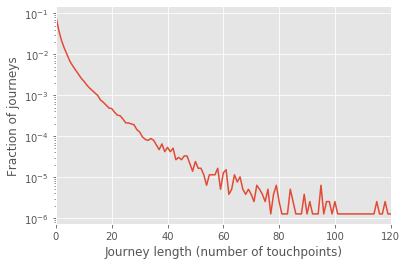

In [0]:
# Data exploration

def journey_lenght_histogram(df):
    counts = df.groupby(['jid'])['uid'].count().reset_index(name="count").groupby(['count']).count()
    return counts.index, counts.values / df.shape[0]

hist_x, hist_y = journey_lenght_histogram(df4)

#plt.plot(range(len(hist_x)), hist_x, label='index journeys')
plt.plot(range(len(hist_y)), hist_y, label='touch journeys')
plt.yscale('log')
plt.xlim(0, 120)
plt.xlabel('Journey length (number of touchpoints)')
plt.ylabel('Fraction of journeys')
plt.show()

# Last Touch Attribution

In [0]:
def last_touch_attribution(df):
    
    def count_by_campaign(df):
        counters = np.zeros(n_campaigns)
        for campaign_one_hot in df['campaigns'].values:
            campaign_id = np.argmax(campaign_one_hot)
            counters[campaign_id] = counters[campaign_id] + 1
        return counters
        
    campaign_impressions = count_by_campaign(df)
    
    df_converted = df[df['conversion'] == 1]
    idx = df_converted.groupby(['jid'])['timestamp_norm'].transform(max) == df_converted['timestamp_norm']
    campaign_conversions = count_by_campaign(df_converted[idx])
        
    return campaign_conversions / campaign_impressions
    
lta = last_touch_attribution(df6)
roi_lta = ((lta[1:50] - (df6.cost.values[1:50]+ df6.cpo.values[1:50]))/(df6.cost.values[1:50]+ df6.cpo.values[1:50]))*100 

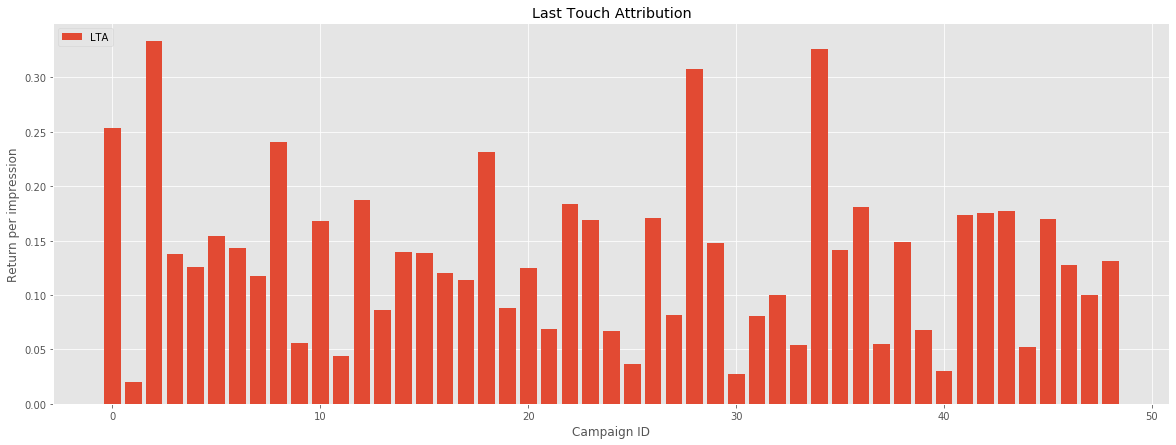

In [0]:
# Visualization of the attribution scores

campaign_idx = range(1, 50)

fig = plt.figure(figsize=(20,7))
ax = fig.add_subplot(111)
plt.bar( range(len(lta[campaign_idx])), lta[campaign_idx], label='LTA' )
plt.xlabel('Campaign ID')
plt.ylabel('Return per impression')
plt.legend(loc='upper left')
plt.title('Last Touch Attribution')
plt.show()

In [0]:
# Visualization of the ROI

campaign_idx = range(1, 50)

fig = plt.figure(figsize=(20,7))
ax = fig.add_subplot(111)
plt.bar( range(len(lta[campaign_idx])), roi_lta, label='LTA' )
plt.xlabel('Campaign ID')
plt.ylabel('Return on Investment in %')
plt.legend(loc='upper left')
plt.title('Last Touch Attribution ROI')
plt.show()

# First Touch Attribution

In [0]:
def first_touch_attribution(df):
    
    def count_by_campaign(df):
        counters = np.zeros(n_campaigns)
        for campaign_one_hot in df['campaigns'].values:
            campaign_id = np.argmax(campaign_one_hot)
            counters[campaign_id] = counters[campaign_id] + 1
        return counters
        
    campaign_impressions = count_by_campaign(df)
    
    #df_converted = df[df['click_nb'].between(0,2, inclusive=True)]
    df_converted_first_click = df[df['conversion']==1]
    idx = df_converted_first_click.groupby(['jid'])['timestamp_norm'].transform(min) == df_converted_first_click['timestamp_norm']
    campaign_conversions = count_by_campaign(df_converted_first_click[idx])
        
    return campaign_conversions / campaign_impressions
#df_touchpoints = filter_journeys_by_length(df2, 10)
fta = first_touch_attribution(df6)
roi_fta = ((fta[1:50] - (df6.cost.values[1:50]+ df6.cpo.values[1:50]))/(df6.cost.values[1:50]+ df6.cpo.values[1:50]))*100 

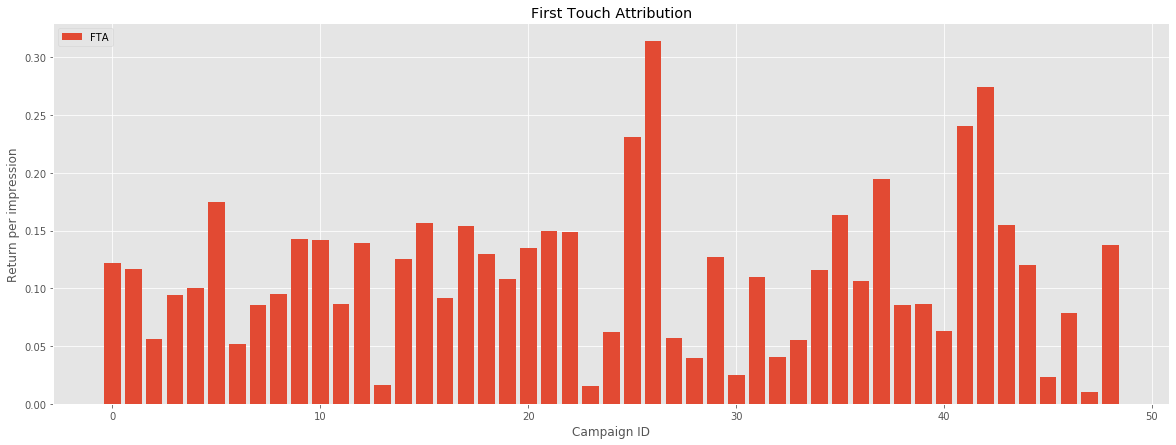

In [0]:
# Visualization of the attribution scores

campaign_idx = range(1, 50)

fig = plt.figure(figsize=(20,7))
ax = fig.add_subplot(111)
plt.bar( range(len(fta[campaign_idx])), fta[campaign_idx], label='FTA' )
plt.xlabel('Campaign ID')
plt.ylabel('Return per impression')
plt.legend(loc='upper left')
plt.title('First Touch Attribution')
plt.show()

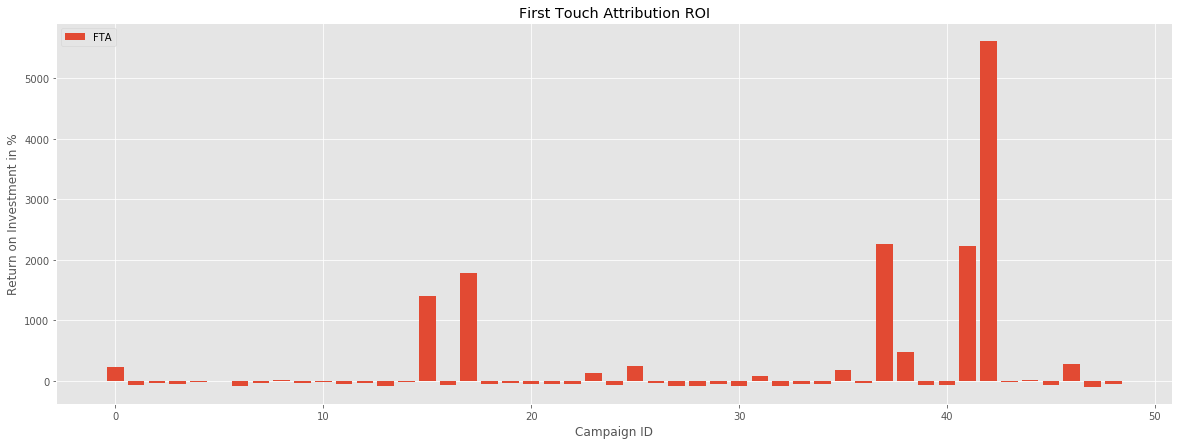

In [0]:
# Visualization of the ROI

campaign_idx = range(1, 50)

fig = plt.figure(figsize=(20,7))
ax = fig.add_subplot(111)
plt.bar( range(len(fta[campaign_idx])), roi_fta, label='FTA' )
plt.xlabel('Campaign ID')
plt.ylabel('Return on Investment in %')
plt.legend(loc='upper left')
plt.title('First Touch Attribution ROI')
plt.show()

# Linear Attribution.

In [0]:
def linear_attribution(df):
    
    def count_by_campaign(df):
        counters = np.zeros(n_campaigns)
        for campaign_one_hot in df['campaigns'].values:
            campaign_id = np.argmax(campaign_one_hot)
            counters[campaign_id] = counters[campaign_id] + 1
        return counters
            
        
    campaign_impressions = count_by_campaign(df)
    
    df_converted = df[df['conversion']==1]
    #df[df['conversion']==1 & (df['click_nb']==2)]
    #idx = df_converted.groupby(['jid'])['timestamp_norm'].transform(max) == df_converted['timestamp_norm']
    idx = df_converted.groupby(['jid'])['timestamp_norm'].transform(sorted) == df_converted['timestamp_norm']
    campaign_conversions = count_by_campaign(df_converted[idx])
        
    return campaign_conversions / campaign_impressions
    
la = linear_attribution(df6)
roi_la = ((la[1:50] - (df6.cost.values[1:50]+ df6.cpo.values[1:50]))/(df6.cost.values[1:50]+ df6.cpo.values[1:50]))*100

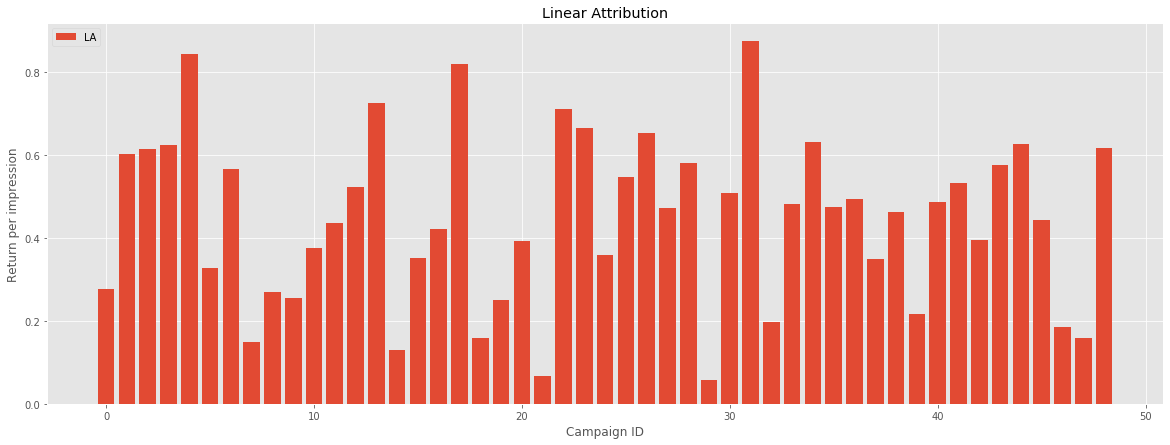

In [0]:
# Visualization of the attribution scores

campaign_idx = range(1, 50)

fig = plt.figure(figsize=(20,7))
ax = fig.add_subplot(111)
plt.bar( range(len(la[campaign_idx])), la[campaign_idx], label='LA' )
plt.xlabel('Campaign ID')
plt.ylabel('Return per impression')
plt.title('Linear Attribution')
plt.legend(loc='upper left')
plt.show()

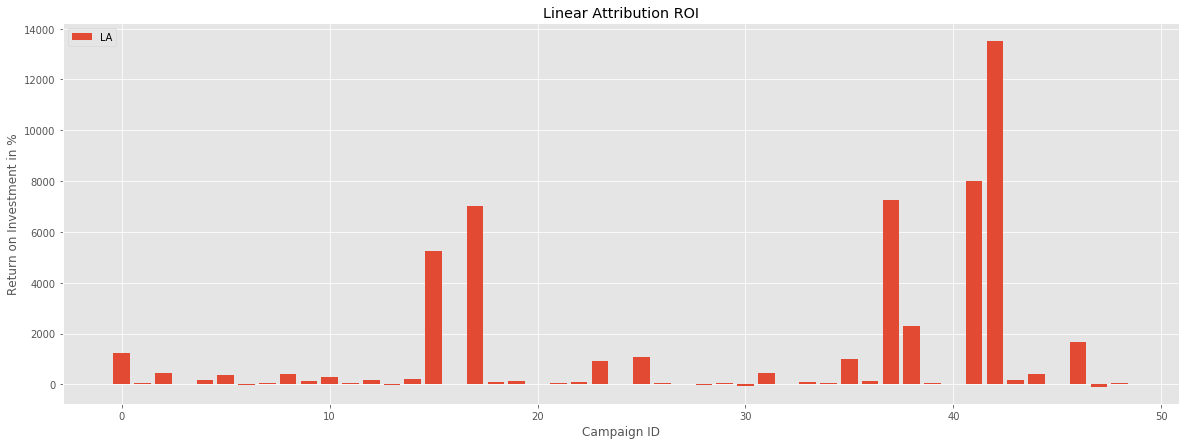

In [0]:
# Visualization of the ROI

campaign_idx = range(1, 50)

fig = plt.figure(figsize=(20,7))
ax = fig.add_subplot(111)
plt.bar( range(len(la[campaign_idx])), roi_la, label='LA' )
plt.xlabel('Campaign ID')
plt.ylabel('Return on Investment in %')
plt.title('Linear Attribution ROI')
plt.legend(loc='upper left')
plt.show()

# Time decay

In [0]:
def time_decay_attribution(df):
    discount_factor = 0.5 # As the touch points get further away, the credit will reduce. 
    # count the number of events for each campaign in df
    
    def count_by_campaign(df):                         
        counters = np.zeros(n_campaigns)
        for campaign_one_hot in df['campaigns'].values:
            campaign_id = np.argmax(campaign_one_hot)
            counters[campaign_id] = counters[campaign_id] + 1
        return counters
    
    def discount_by_campaign(df):                         
        counters = np.zeros(n_campaigns)
        for campaign_one_hot in df['campaigns'].values:
            campaign_id = np.argmax(campaign_one_hot)
            for i in range(campaign_id + 1):
                """
                Multiplying 1 with the discount factor to the power of
                campaign id - current campaign number. This way, the 
                earlier campaign are assigned a lower value, while the 
                later campaigns are assigned a higher value. The latest
                campaign gets multiplied with 0.5 to the power of 0, 
                therefore 1 gets attached to it. 
                """
                counters[i] +=  1*((discount_factor)**(campaign_id-i))
        return counters
                
                
                
    # count the number of impressions for each campaign
    campaign_impressions = count_by_campaign(df)       
    
    # count the number of times the campaign is the last touch before the conversion
    dfc = df[df['conversion'] == 1]
    
    idx = dfc.groupby(['jid'])['timestamp_norm'].transform(min) == dfc['timestamp_norm']
    campaign_conversions = discount_by_campaign(dfc[idx])
        
    return campaign_conversions / campaign_impressions

tda = time_decay_attribution(df6)
roi_tda = ((tda[1:50] - (df6.cost.values[1:50]+ df6.cpo.values[1:50]))/(df6.cost.values[1:50]+ df6.cpo.values[1:50]))*100 

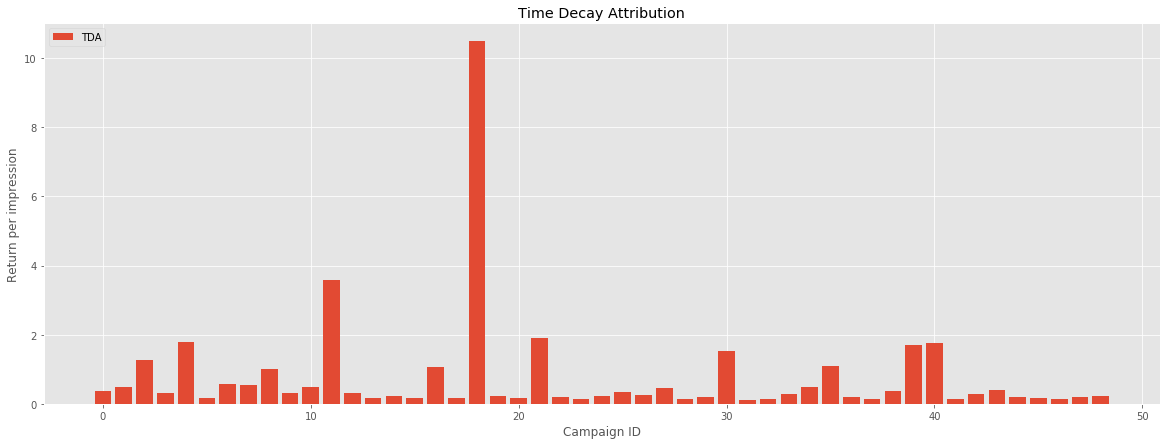

In [0]:
# Visualization of the attribution scores

campaign_idx = range(1, 50)

fig = plt.figure(figsize=(20,7))
ax = fig.add_subplot(111)
plt.bar( range(len(tda[campaign_idx])), tda[campaign_idx], label='TDA' )
plt.xlabel('Campaign ID')
plt.ylabel('Return per impression')
plt.title('Time Decay Attribution')
plt.legend(loc='upper left')
plt.show()

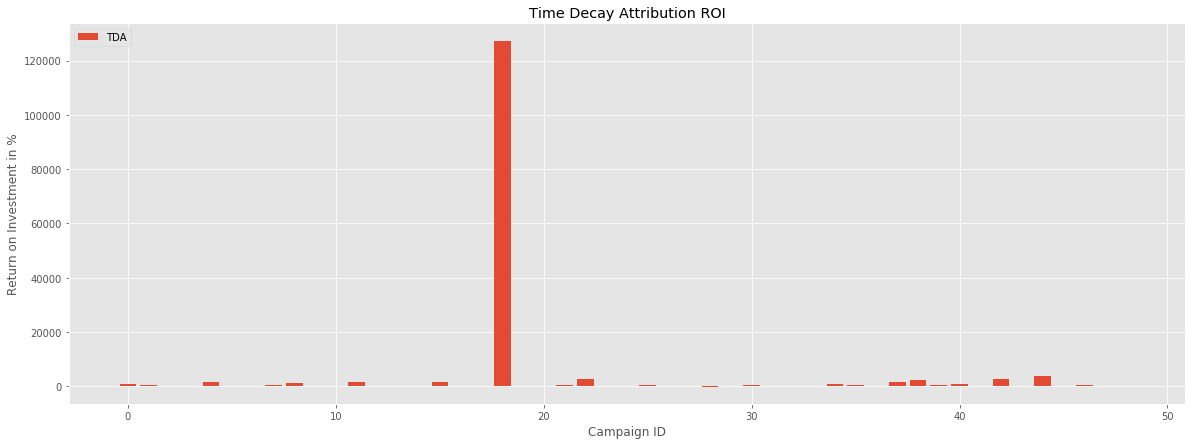

In [0]:
# Visualization of the ROI

campaign_idx = range(1, 50)

fig = plt.figure(figsize=(20,7))
ax = fig.add_subplot(111)
plt.bar( range(len(tda[campaign_idx])), roi_tda, label='TDA' )
plt.xlabel('Campaign ID')
plt.ylabel('Return on Investment in %')
plt.title('Time Decay Attribution ROI')
plt.legend(loc='upper left')
plt.show()

# U-Shaped Attribution

In [0]:
def U_shape_attribution(df):
    # count the number of events for each campaign in df
    def count_by_campaign(df):                         
        counters = np.zeros(n_campaigns)
        for campaign_one_hot in df['campaigns'].values:
            campaign_id = np.argmax(campaign_one_hot)
            counters[campaign_id] = counters[campaign_id] + 1
        return counters
    
    def ushape_campaign(df):                         
        counters = np.zeros(n_campaigns)
        for campaign_one_hot in df['campaigns'].values:
            campaign_id = np.argmax(campaign_one_hot)
            counters[campaign_id] = counters[campaign_id] + 0.5 # Adding 5 to max. 
            for i in range(campaign_id):
                if i == 0: 
                    counters[i] += 0.5 # Adding 5 to min.
                else:
                  counters[i] += 0.2
        return counters 
                
    # count the number of impressions for each campaign
    campaign_impressions = count_by_campaign(df)       
    
    # count the number of times the campaign is the last touch before the conversion
    dfc = df[df['conversion'] == 1]
    
    idx = dfc.groupby(['jid'])['timestamp_norm'].transform(sorted) == dfc['timestamp_norm']
    campaign_conversions = ushape_campaign(dfc[idx])
        
    return campaign_conversions / campaign_impressions

usa = U_shape_attribution(df6)
roi_usa =  ((usa[1:50] - (df6.cost.values[1:50]+ df6.cpo.values[1:50]))/(df6.cost.values[1:50]+ df6.cpo.values[1:50]))*100 

In [0]:
pd.DataFrame(roi_usa)[0]

0     4.000968e+04
1     1.357249e+04
2     4.929873e+03
3     1.260900e+03
4     3.869484e+04
5     1.283025e+03
6     8.658174e+03
7     1.238156e+04
8     4.083476e+04
9     2.426853e+03
10    4.205073e+03
11    2.580335e+04
12    1.004609e+03
13    7.816753e+02
14    5.519751e+03
15    1.241245e+05
16    3.595376e+04
17    3.581497e+03
18    5.654923e+06
19    2.762375e+03
20    1.654580e+03
21    3.440227e+04
22    8.536410e+04
23    2.837618e+03
24    1.217616e+04
25    4.759979e+04
26    3.882086e+03
27    7.792775e+03
28    1.201411e+03
29    6.381439e+03
30    6.315879e+04
31    1.347031e+04
32    5.070115e+03
33    1.986109e+04
34    3.466738e+04
35    2.064450e+04
36    3.340752e+03
37    8.331553e+04
38    1.359031e+05
39    1.878907e+04
40    1.456650e+04
41    1.112546e+03
42    5.144924e+04
43    2.825863e+03
44    1.585321e+05
45    7.557339e+03
46    5.936878e+04
47    1.657439e+04
48    1.106041e+04
Name: 0, dtype: float64

In [0]:
df_models = pd.read_csv('/content/All_Models.csv')
df_models['2'].head()

0    1278.368136
1      19.202460
2     110.748708
3    1005.483216
4      61.308556
Name: 2, dtype: float64

In [0]:
df_models[df_models['Model']=='Time Decay Attribution'].loc[:,'2']=

49     1278.368136
50       19.202460
51      110.748708
52     1005.483216
53       61.308556
54      303.427972
55      250.993901
56     4876.349118
57       22.357273
58      635.273936
59      -17.617153
60      144.420449
61      106.334801
62      -19.387312
63      122.326588
64     4513.506820
65     1982.367766
66       14.960728
67    46273.584984
68       -2.104595
69       68.254536
70      377.993170
71     7637.816390
72      -55.046050
73       21.161047
74     1006.158026
75      740.892370
76      -43.094016
77      -65.478935
78      104.496104
79       15.145799
80      333.904285
81     1004.054787
82        7.408227
83     8930.904232
84       59.648752
85      283.072421
86     8589.685673
87      986.003987
88      513.618170
89     3396.701757
90       -5.809735
91     3612.234168
92      129.139631
93      208.028688
94      288.657870
95     1260.151615
96       84.648723
97       53.446495
Name: 2, dtype: float64

In [0]:
df_models[df_models['Model']=='U Shaped Attribution']['2']

In [0]:
df_models[df_models['Model']=='U Shaped Attribution']['2']

0      1278.368136
1        19.202460
2       110.748708
3      1005.483216
4        61.308556
5       303.427972
6       250.993901
7      4876.349118
8        22.357273
9       635.273936
10      -17.617153
11      144.420449
12      106.334801
13      -19.387312
14      122.326588
15     4513.506820
16     1982.367766
17       14.960728
18    46273.584984
19       -2.104595
20       68.254536
21      377.993170
22     7637.816390
23      -55.046050
24       21.161047
25     1006.158026
26      740.892370
27      -43.094016
28      -65.478935
29      104.496104
30       15.145799
31      333.904285
32     1004.054787
33        7.408227
34     8930.904232
35       59.648752
36      283.072421
37     8589.685673
38      986.003987
39      513.618170
40     3396.701757
41       -5.809735
42     3612.234168
43      129.139631
44      208.028688
45      288.657870
46     1260.151615
47       84.648723
48       53.446495
Name: 2, dtype: float64

In [0]:
df_models[df_models['Model']=='Time Decay Attribution']['2']

49     1278.368136
50       19.202460
51      110.748708
52     1005.483216
53       61.308556
54      303.427972
55      250.993901
56     4876.349118
57       22.357273
58      635.273936
59      -17.617153
60      144.420449
61      106.334801
62      -19.387312
63      122.326588
64     4513.506820
65     1982.367766
66       14.960728
67    46273.584984
68       -2.104595
69       68.254536
70      377.993170
71     7637.816390
72      -55.046050
73       21.161047
74     1006.158026
75      740.892370
76      -43.094016
77      -65.478935
78      104.496104
79       15.145799
80      333.904285
81     1004.054787
82        7.408227
83     8930.904232
84       59.648752
85      283.072421
86     8589.685673
87      986.003987
88      513.618170
89     3396.701757
90       -5.809735
91     3612.234168
92      129.139631
93      208.028688
94      288.657870
95     1260.151615
96       84.648723
97       53.446495
Name: 2, dtype: float64

In [0]:
roi_usa

array([4.00096795e+04, 1.35724912e+04, 4.92987264e+03, 1.26090049e+03,
       3.86948362e+04, 1.28302477e+03, 8.65817414e+03, 1.23815603e+04,
       4.08347577e+04, 2.42685256e+03, 4.20507334e+03, 2.58033545e+04,
       1.00460876e+03, 7.81675257e+02, 5.51975054e+03, 1.24124489e+05,
       3.59537604e+04, 3.58149750e+03, 5.65492294e+06, 2.76237505e+03,
       1.65458008e+03, 3.44022671e+04, 8.53640984e+04, 2.83761845e+03,
       1.21761562e+04, 4.75997925e+04, 3.88208598e+03, 7.79277527e+03,
       1.20141075e+03, 6.38143939e+03, 6.31587890e+04, 1.34703054e+04,
       5.07011521e+03, 1.98610925e+04, 3.46673752e+04, 2.06445030e+04,
       3.34075210e+03, 8.33155321e+04, 1.35903136e+05, 1.87890740e+04,
       1.45665030e+04, 1.11254559e+03, 5.14492387e+04, 2.82586308e+03,
       1.58532132e+05, 7.55733933e+03, 5.93687787e+04, 1.65743916e+04,
       1.10604102e+04])

In [0]:
 roi_df = pd.DataFrame(roi_usa)

In [0]:
double(roi_df.loc[0,0])

40009.67954694268

In [0]:
df_models['Model'].unique()

array(['U Shaped Attribution', 'Time Decay Attribution',
       'Last Touch Attribution', 'First Touch Attribution',
       'Linear Attribution'], dtype=object)

In [0]:
df_models.to_csv(r'All_Models_Update.csv', index = False)

In [0]:
df_models[df_models['Model']=='Time Decay Attribution']['2']

49     1278.368136
50       19.202460
51      110.748708
52     1005.483216
53       61.308556
54      303.427972
55      250.993901
56     4876.349118
57       22.357273
58      635.273936
59      -17.617153
60      144.420449
61      106.334801
62      -19.387312
63      122.326588
64     4513.506820
65     1982.367766
66       14.960728
67    46273.584984
68       -2.104595
69       68.254536
70      377.993170
71     7637.816390
72      -55.046050
73       21.161047
74     1006.158026
75      740.892370
76      -43.094016
77      -65.478935
78      104.496104
79       15.145799
80      333.904285
81     1004.054787
82        7.408227
83     8930.904232
84       59.648752
85      283.072421
86     8589.685673
87      986.003987
88      513.618170
89     3396.701757
90       -5.809735
91     3612.234168
92      129.139631
93      208.028688
94      288.657870
95     1260.151615
96       84.648723
97       53.446495
Name: 2, dtype: float64

In [0]:
df_models[df_models['Model']=='U Shaped Attribution']['2']

0     4.000968e+04
1     1.357249e+04
2     4.929873e+03
3     1.260900e+03
4     3.869484e+04
5     1.283025e+03
6     8.658174e+03
7     1.238156e+04
8     4.083476e+04
9     2.426853e+03
10    4.205073e+03
11    2.580335e+04
12    1.004609e+03
13    7.816753e+02
14    5.519751e+03
15    1.241245e+05
16    3.595376e+04
17    3.581497e+03
18    5.654923e+06
19    2.762375e+03
20    1.654580e+03
21    3.440227e+04
22    8.536410e+04
23    2.837618e+03
24    1.217616e+04
25    4.759979e+04
26    3.882086e+03
27    7.792775e+03
28    1.201411e+03
29    6.381439e+03
30    6.315879e+04
31    1.347031e+04
32    5.070115e+03
33    1.986109e+04
34    3.466738e+04
35    2.064450e+04
36    3.340752e+03
37    8.331553e+04
38    1.359031e+05
39    1.878907e+04
40    1.456650e+04
41    1.112546e+03
42    5.144924e+04
43    2.825863e+03
44    1.585321e+05
45    7.557339e+03
46    5.936878e+04
47    1.657439e+04
48    1.106041e+04
Name: 2, dtype: float64

In [0]:
for i in range(49):
  df_models[df_models['Model']=='U Shaped Attribution'].loc[i, '2'] = double(roi_df.loc[i,0])

#df_models[df_models['Model']=='U Shaped Attribution'].loc[1, '2']

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [0]:
df_models[df_models['Model']=='U Shaped Attribution']['2']=roi_df.loc[0:48]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


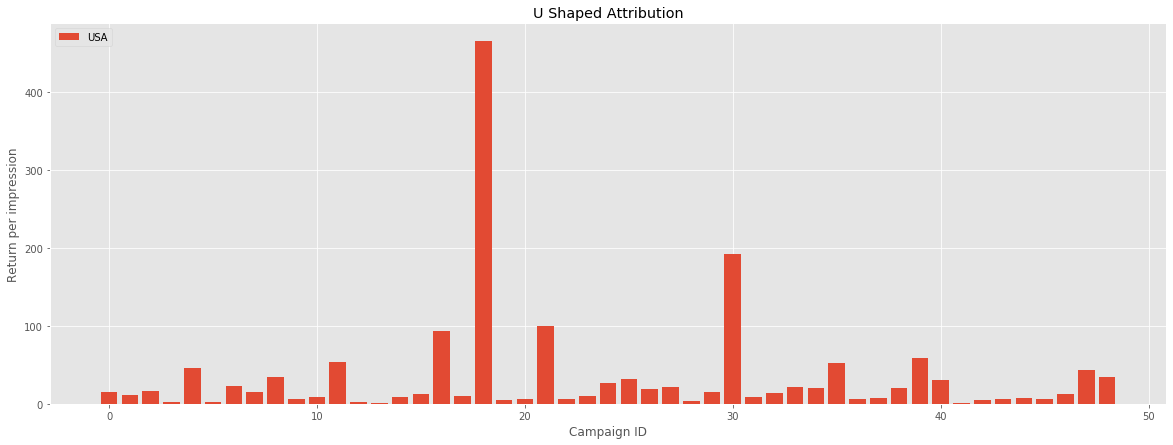

In [0]:
# Visualization of the attribution scores

campaign_idx = range(1, 50)

fig = plt.figure(figsize=(20,7))
ax = fig.add_subplot(111)
plt.bar( range(len(usa[campaign_idx])), usa[campaign_idx], label='USA' )
plt.xlabel('Campaign ID')
plt.ylabel('Return per impression')
plt.title('U Shaped Attribution')
plt.legend(loc='upper left')
plt.show()

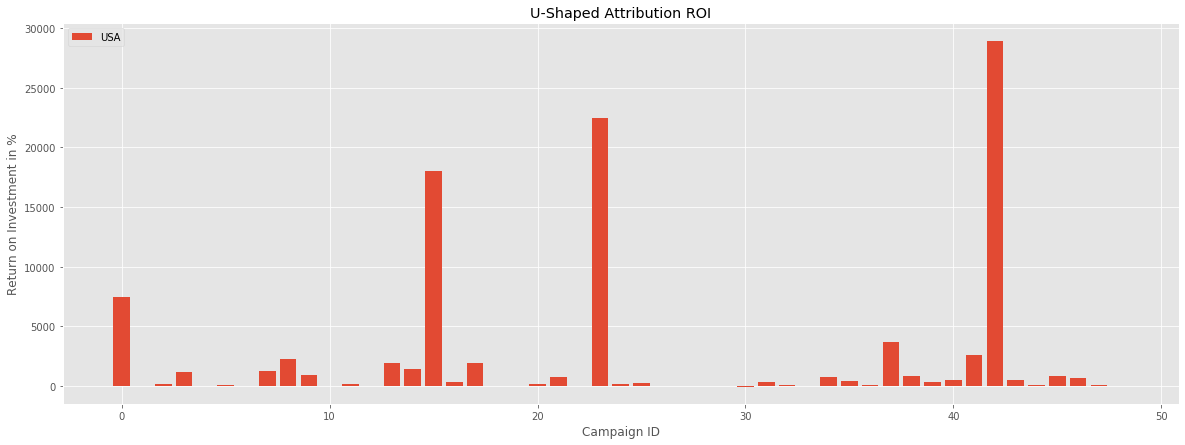

In [0]:
# Visualization of the ROI

campaign_idx = range(1, 50)

fig = plt.figure(figsize=(20,7))
ax = fig.add_subplot(111)
plt.bar( range(len(usa[campaign_idx])), roi_usa, label='USA' )
plt.xlabel('Campaign ID')
plt.ylabel('Return on Investment in %')
plt.title('U-Shaped Attribution ROI')
plt.legend(loc='upper left')
plt.show()

In [0]:
# How to run a Dash app in Google Colab

### Install ngrok
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

### Install Dash
#!pip install dash==0.31.1  # The core dash backend
#!pip install dash-html-components==0.13.2  # HTML components
#!pip install dash-core-components==0.39.0  # Supercharged components
#!pip install dash-table==3.1.7  # Interactive DataTable component (new!)
!pip install dash  # The core dash backend
!pip install dash-html-components  # HTML components
!pip install dash-core-components  # Supercharged components
!pip install dash-table  # Interactive DataTable component (new!)

--2020-03-14 00:34:06--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 34.197.77.37, 34.192.78.186, 34.227.168.133, ...
Connecting to bin.equinox.io (bin.equinox.io)|34.197.77.37|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13773305 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip.1’

ngrok-stable-linux- 100%[===================>]  13.13M  6.47MB/s    in 2.0s    

2020-03-14 00:34:09 (6.47 MB/s) - ‘ngrok-stable-linux-amd64.zip.1’ saved [13773305/13773305]

Archive:  ngrok-stable-linux-amd64.zip
replace ngrok? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: ngrok                   


In [0]:
!pip install dash==1.4.1  # The core dash backend
!pip install dash-daq==0.2.1

     |████████████████████████████████| 61kB 2.0MB/s 
     |████████████████████████████████| 1.2MB 8.2MB/s 
     |████████████████████████████████| 2.1MB 42.7MB/s 
     |████████████████████████████████| 194kB 60.7MB/s 
     |████████████████████████████████| 1.8MB 26.7MB/s 
  Created wheel for dash: filename=dash-1.4.1-cp36-none-any.whl size=66440 sha256=5361b17157af9672025fffcf6f2b5cd8989f8ad927feef63f95fbd4e6a983d62
  Stored in directory: /root/.cache/pip/wheels/41/11/b7/643b47546d61ba55d7f29325c4952c1639edb8798887bad458
  Created wheel for dash-renderer: filename=dash_renderer-1.1.2-cp36-none-any.whl size=1166890 sha256=4822a9e9f3ae6d260851c1d7ec89e2cfc14f7a86ee42ec73856e376eb267b845
  Stored in directory: /root/.cache/pip/wheels/f6/07/8b/f262dd356b8cb359a5b3f5e4ff9d4ddb85854bd51f824ffa58
  Created wheel for dash-core-components: filename=dash_core_components-1.3.1-cp36-none-any.whl size=2116124 sha256=b087c70086022ce4dc100b844993436906098f07efdd11939f57a742aa0ff79f
  Stored in di

In [0]:
get_ipython().system_raw('./ngrok http 8050 &')

### Get the public URL where you can access the Dash app. Copy this URL.
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

https://6003995b.ngrok.io


In [0]:
### Run Dash app
!python all_model.py

Running on http://127.0.0.1:8050/
Debugger PIN: 357-428-455
 * Serving Flask app "all_model" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on
Running on http://127.0.0.1:8050/
Debugger PIN: 767-053-631
